In [1]:
import gymnasium as gym
import numpy as np
from gymnasium.wrappers import TransformObservation, TimeLimit
import matplotlib.pyplot as plt
from collections import defaultdict

# Tile Coding

In [2]:
def tile_coding(state, num_tilings, tiles_per_dim, state_space_bounds, offset=0.1):
    encoded_state = np.zeros((num_tilings, *([tiles_per_dim] * len(state_space_bounds))))

    for tiling in range(num_tilings):
        tile_indices = []
        for i, (s, bounds) in enumerate(zip(state, state_space_bounds)):
            scale = tiles_per_dim / (bounds[1] - bounds[0] + offset * (num_tilings - 1))
            tiling_offset = tiling * offset / tiles_per_dim

            tile_index = np.floor(scale * (s - bounds[0] + tiling_offset)).astype(int) % tiles_per_dim
            tile_indices.append(tile_index)

        encoded_state[(tiling, *tile_indices)] = 1

    return encoded_state.flatten()

In [5]:
env_variables = {
    'MountainCar-v0': {
        'num_tilings': 4,
        'num_tiles': 10,
        'offset': 0.2,
        'bounds': [(-1.2, 0.6), (-0.07, 0.07)],
        'practical_bounds': [(-1.2, 0.6), (-0.07, 0.07)],
        'num_actions': 3,
        'max_episode_steps': 10000
    },
    'CartPole-v1': {
        'num_tilings': 4,
        'num_tiles': 10,
        'offset': 0.2,
        'bounds': [(-2.4, 2.4), (-np.inf, np.inf), (-0.5, 0.5), (-np.inf, np.inf)],
        'practical_bounds': [(-2.4, 2.4), (-5.0, 5.0), (-0.418, 0.418), (-5.0, 5.0)],
        'num_actions': 2,
        'max_episode_steps': 5000
    }
}



# Part 2

In [6]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)  # only difference

class ReinforceAgent:
    def __init__(self, env, num_actions, state_space_dim, temperature=1.0):
        self.theta = np.random.rand(state_space_dim, num_actions)  # policy parameters
        self.env = env
        self.num_actions = num_actions
        self.temperature = temperature

    def policy(self, state):
        z = state.dot(self.theta)
        return softmax(z / self.temperature)

    def act(self, state):
        probs = self.policy(state)
        action = np.random.choice(self.num_actions, p=probs)
        return action

    def update_policy(self, rewards, states, actions):
        G = 0
        for t in reversed(range(len(rewards))):
            G = G * self.gamma + rewards[t]
            theta_gradient = np.zeros_like(self.theta)
            pi = self.policy(states[t])
            theta_gradient[:, actions[t]] = states[t] * (1 - pi[actions[t]])
            for a in range(self.num_actions):
                if a != actions[t]:
                    theta_gradient[:, a] = -states[t] * pi[a]
            self.theta += self.alpha / (self.temperature ** 2) * G * theta_gradient


In [7]:
import numpy as np

class ActorCriticAgent:
    def __init__(self, num_features, num_actions, alpha_theta=0.01, alpha_w=0.01, gamma=0.99, epsilon=0.25):
        self.theta = np.random.rand(num_features, num_actions)  # policy parameters
        self.w = np.random.rand(num_features)  # value function parameters
        self.alpha_theta = alpha_theta  # learning rate for the actor
        self.alpha_w = alpha_w  # learning rate for the critic
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # exploration rate
        self.num_actions = num_actions

    def policy(self, state):
        z = state.dot(self.theta)
        exp = np.exp(z - np.max(z))  # for numerical stability
        return exp / np.sum(exp)

    def act(self, state, use_greedy=False):
        if use_greedy:
            action = np.argmax(self.policy(state))  # Always choose the greedy action
        elif np.random.rand() < self.epsilon:
            action = np.argmax(self.policy(state))  # Epsilon-greedy action selection
        else:
            probs = self.policy(state)
            action = np.random.choice(self.num_actions, p=probs)
        return action

    def value(self, state):
        return state.dot(self.w)

    def update(self, state, action, reward, next_state, done):
        # Compute the TD error
        td_target = reward + (0 if done else self.gamma * self.value(next_state))
        td_error = td_target - self.value(state)

        # Update the critic
        self.w += self.alpha_w * td_error * state

        # Update the actor
        probs = self.policy(state)
        dlogp = np.zeros_like(probs)
        dlogp[action] = 1
        grad_theta = (dlogp - probs) * state[:, None]
        self.theta += self.alpha_theta * td_error * grad_theta


In [8]:

# cp_bounds=[(-2.4, 2.4), (-np.inf, np.inf), (-0.5, 0.5), (-np.inf, np.inf)]
# cp_practical_bounds = [(-2.4, 2.4), (-5.0, 5.0), (-0.418, 0.418), (-5.0, 5.0)]



# num_tilings = 8
# tiles_per_tiling = 8
# state_space_dim = num_tilings * (tiles_per_tiling ** len(cp_practical_bounds))

def clip_state(state, bounds):
    clipped_state = np.clip(state, [b[0] for b in bounds], [b[1] for b in bounds])
    return clipped_state


# alpha = 0.1
# gamma = 1.0
# epsilon = 0.1

# env = gym.make("CartPole-v1")
# agent = ActorCriticAgent(state_space_dim, env.action_space.n)
# env = TransformObservation(env, lambda state : tile_coding(clip_state(state, cp_practical_bounds), num_tilings, tiles_per_tiling, cp_practical_bounds))

# num_episodes = 1000

# for episode in range(num_episodes):
#     observation, _ = env.reset()
#     done = False

#     while not done:
#         action = agent.act(observation)
#         new_observation, reward, terminated, truncated, _ = env.step(action)
#         done = terminated or truncated
#         agent.update(observation, action, reward, new_observation, done)
#         observation = new_observation

In [9]:
env_variables = {
    'MountainCar-v0': {
        'num_tilings': 8,
        'num_tiles': 8,
        'offset': 0.1,
        'bounds': [(-1.2, 0.6), (-0.07, 0.07)],
        'practical_bounds': [(-1.2, 0.6), (-0.07, 0.07)],
        'num_actions': 3,
        'max_episode_steps': 10000
    },
    'CartPole-v1': {
        'num_tilings': 8,
        'num_tiles': 8,
        'offset': 0.1,
        'bounds': [(-2.4, 2.4), (-np.inf, np.inf), (-0.5, 0.5), (-np.inf, np.inf)],
        'practical_bounds': [(-2.4, 2.4), (-5.0, 5.0), (-0.418, 0.418), (-5.0, 5.0)],
        'num_actions': 2,
        'max_episode_steps': 500
    }
}

In [10]:
def run_experiment(env_name, num_tilings, num_tiles, practical_bounds, num_runs, num_episodes, max_episode_steps, offset=0.1):
    # Store the rewards for each run
    run_rewards = defaultdict(lambda: [])
    test_run_rewards = defaultdict(lambda: [])
    env = gym.make(env_name)
    env = TransformObservation(env, lambda state : tile_coding(clip_state(state, practical_bounds), num_tilings, num_tiles, practical_bounds))
    state_space_dim = num_tilings * (num_tiles ** len(practical_bounds))
    agent = ActorCriticAgent(state_space_dim, env.action_space.n)

    for run in range(num_runs):
        agent = ActorCriticAgent(state_space_dim, env.action_space.n)
        total_rewards = []
        test_total_rewards = []

        for episode in range(num_episodes):
            observation, _ = env.reset()
            done = False
            total_reward = 0

            while not done:
                action = agent.act(observation)
                new_observation, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                agent.update(observation, action, reward, new_observation, done)
                observation = new_observation
                total_reward += reward

            observation, _ = env.reset()
            done = False
            test_total_reward = 0
            while not done:
                action = agent.act(observation, use_greedy=True)
                new_observation, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                observation = new_observation
                test_total_reward += reward

            total_rewards.append(total_reward)
            test_total_rewards.append(test_total_reward)
        run_rewards['Run {}'.format(run + 1)] = total_rewards
        test_run_rewards['Run {}'.format(run + 1)] = test_total_rewards
    env.close()

    return run_rewards, test_run_rewards

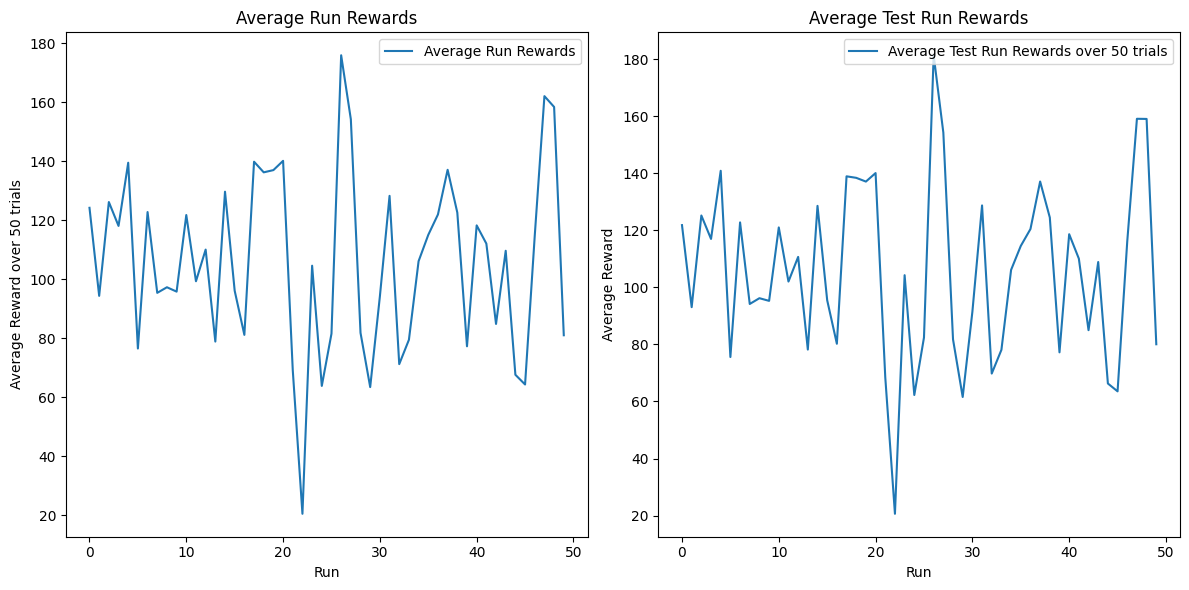

In [11]:
en = 'CartPole-v1'
en_v = env_variables[en]
rr, trr = run_experiment(en, en_v['num_tilings'], en_v['num_tiles'], en_v['practical_bounds'], 50, 1000, en_v['max_episode_steps'])

def plot_average_rewards(run_rewards, test_run_rewards):
    plt.figure(figsize=(12, 6))

    # Calculate and plot average rewards for each run in run_rewards
    plt.subplot(1, 2, 1)
    avg_run_rewards = [np.mean(rewards) for rewards in run_rewards.values()]
    plt.plot(avg_run_rewards, label="Average Run Rewards")
    plt.title("Average Run Rewards")
    plt.xlabel("Run")
    plt.ylabel("Average Reward over 50 trials")
    plt.legend()

    # Calculate and plot average rewards for each run in test_run_rewards
    plt.subplot(1, 2, 2)
    avg_test_run_rewards = [np.mean(rewards) for rewards in test_run_rewards.values()]
    plt.plot(avg_test_run_rewards, label="Average Test Run Rewards over 50 trials")
    plt.title("Average Test Run Rewards")
    plt.xlabel("Run")
    plt.ylabel("Average Reward")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_average_rewards(rr, trr)

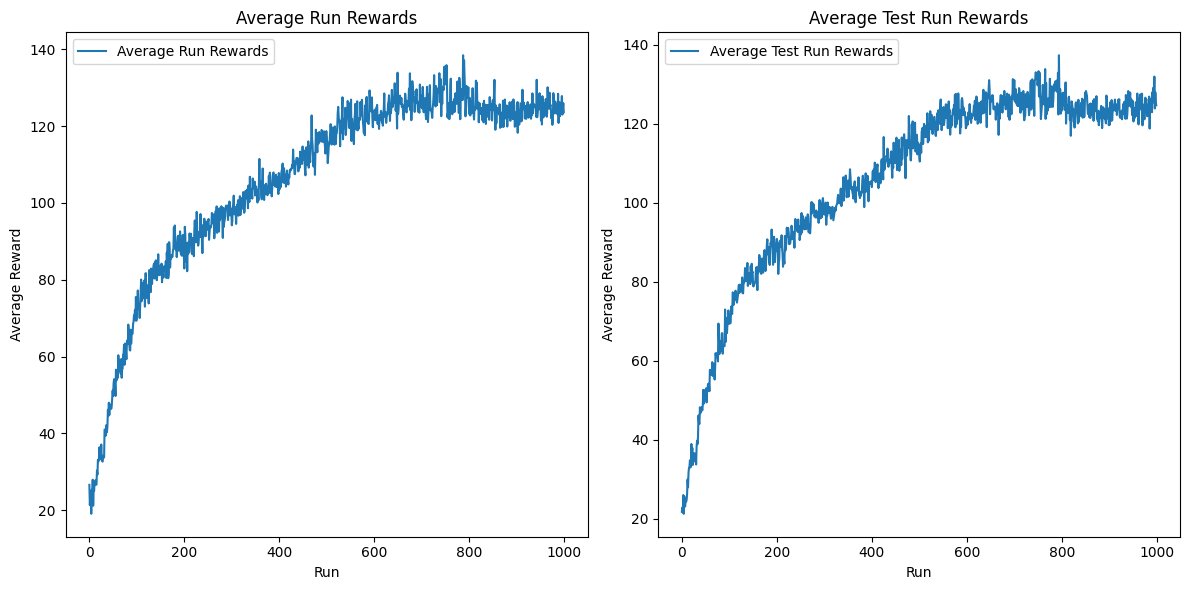

In [12]:
def plot_average_rewards(run_rewards, test_run_rewards):
    plt.figure(figsize=(12, 6))
    runr = list(run_rewards.values())
    testr = list(test_run_rewards.values())


    # Calculate and plot average rewards for each run in run_rewards
    plt.subplot(1, 2, 1)
    avg_run_rewards = np.mean(runr, axis=0)
    plt.plot(avg_run_rewards, label="Average Run Rewards")
    plt.title("Average Run Rewards")
    plt.xlabel("Run")
    plt.ylabel("Average Reward")
    plt.legend()

    # Calculate and plot average rewards for each run in test_run_rewards
    plt.subplot(1, 2, 2)
    avg_test_run_rewards = np.mean(testr, axis=0)
    plt.plot(avg_test_run_rewards, label="Average Test Run Rewards")
    plt.title("Average Test Run Rewards")
    plt.xlabel("Run")
    plt.ylabel("Average Reward")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_average_rewards(rr, trr)